<div style="padding: 35px;color:white;margin:10;font-size:200%;text-align:center;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://wallpapercosmos.com/w/full/3/d/d/1254787-3840x2160-desktop-4k-mastercard-wallpaper.jpg)"><b><span style='color:black'>Getting Started </span></b> </div>

<br>

![](https://images.pexels.com/photos/1250655/pexels-photo-1250655.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)

<br>

### <b><span style='color:#16C2D5'>|</span> Domain Knowledge</b>

<br>

1. `Gravity` : Urine density relative to water, which indicates the concentration of dissolved substances.

2. `pH` : A scale ranging from 1 to 14 that measures the acidity or alkalinity of an aqueous solution; 7 being neutral.

3. `Osmo` : Osmolality, the concentration of osmoles (particles that contribute to osmotic pressure) in a solution, expressed as milliosmoles per liter (mOsm/L) in biological systems.

4. `Cond` : Electrical conductivity, a measure of a liquid's ability to conduct electricity, which depends on the number of ions per unit volume and their drift velocity.

5. `Urea` : Urea concentration in the urine, measured in millimoles per liter (mmol/L).

6. `Calc` : Calcium concentration in the urine, measured in millimoles per liter (mmol/L).

7. `Target` : The presence (True/False) of a kidney stone based on the analysis of the above urine parameters.

### Column Explanations:



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from mlxtend.classifier import StackingCVClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset
df = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
# drop the 'id' column
df.drop('id', axis=1, inplace=True)

# Exploratory Data Analysis (EDA)

In [3]:
df.columns

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target'], dtype='object')

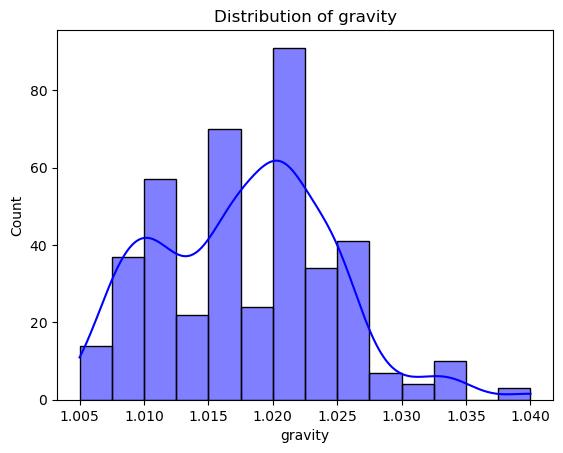

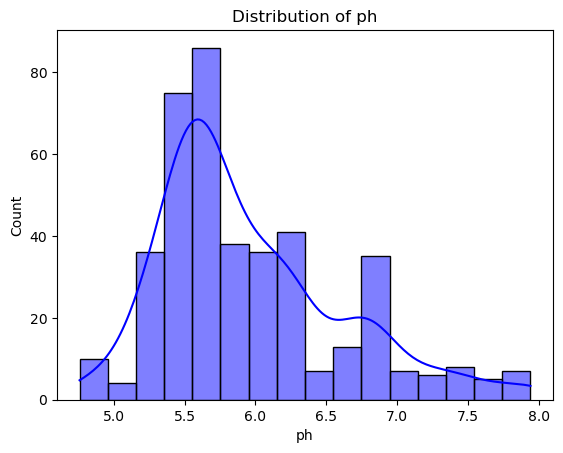

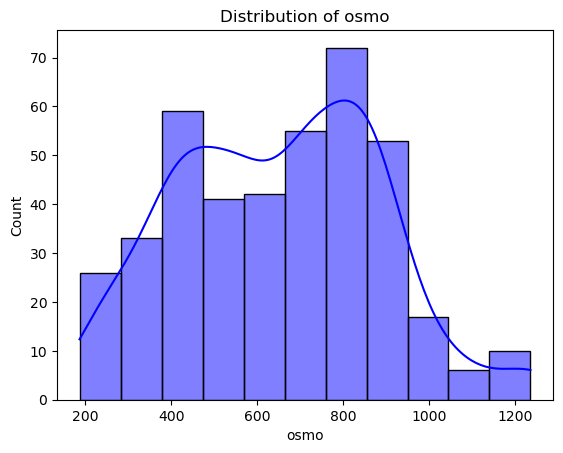

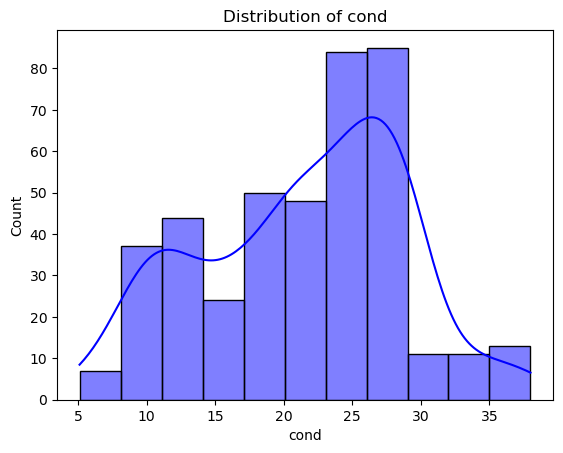

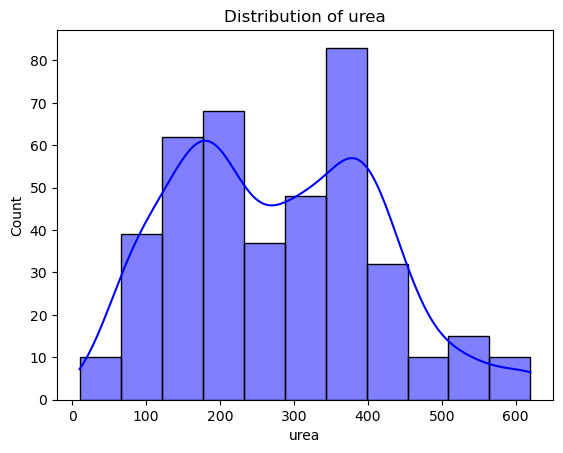

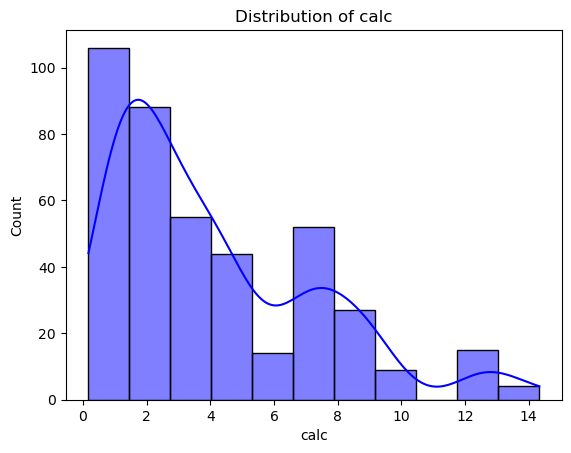

In [4]:
data_without_target = df.drop(columns=['target'])

# Distribution plots
for column in data_without_target.columns:
    plt.figure()
    sns.histplot(data=data_without_target, x=column, kde=True, color='blue')
    plt.title(f'Distribution of {column}')
    plt.show()

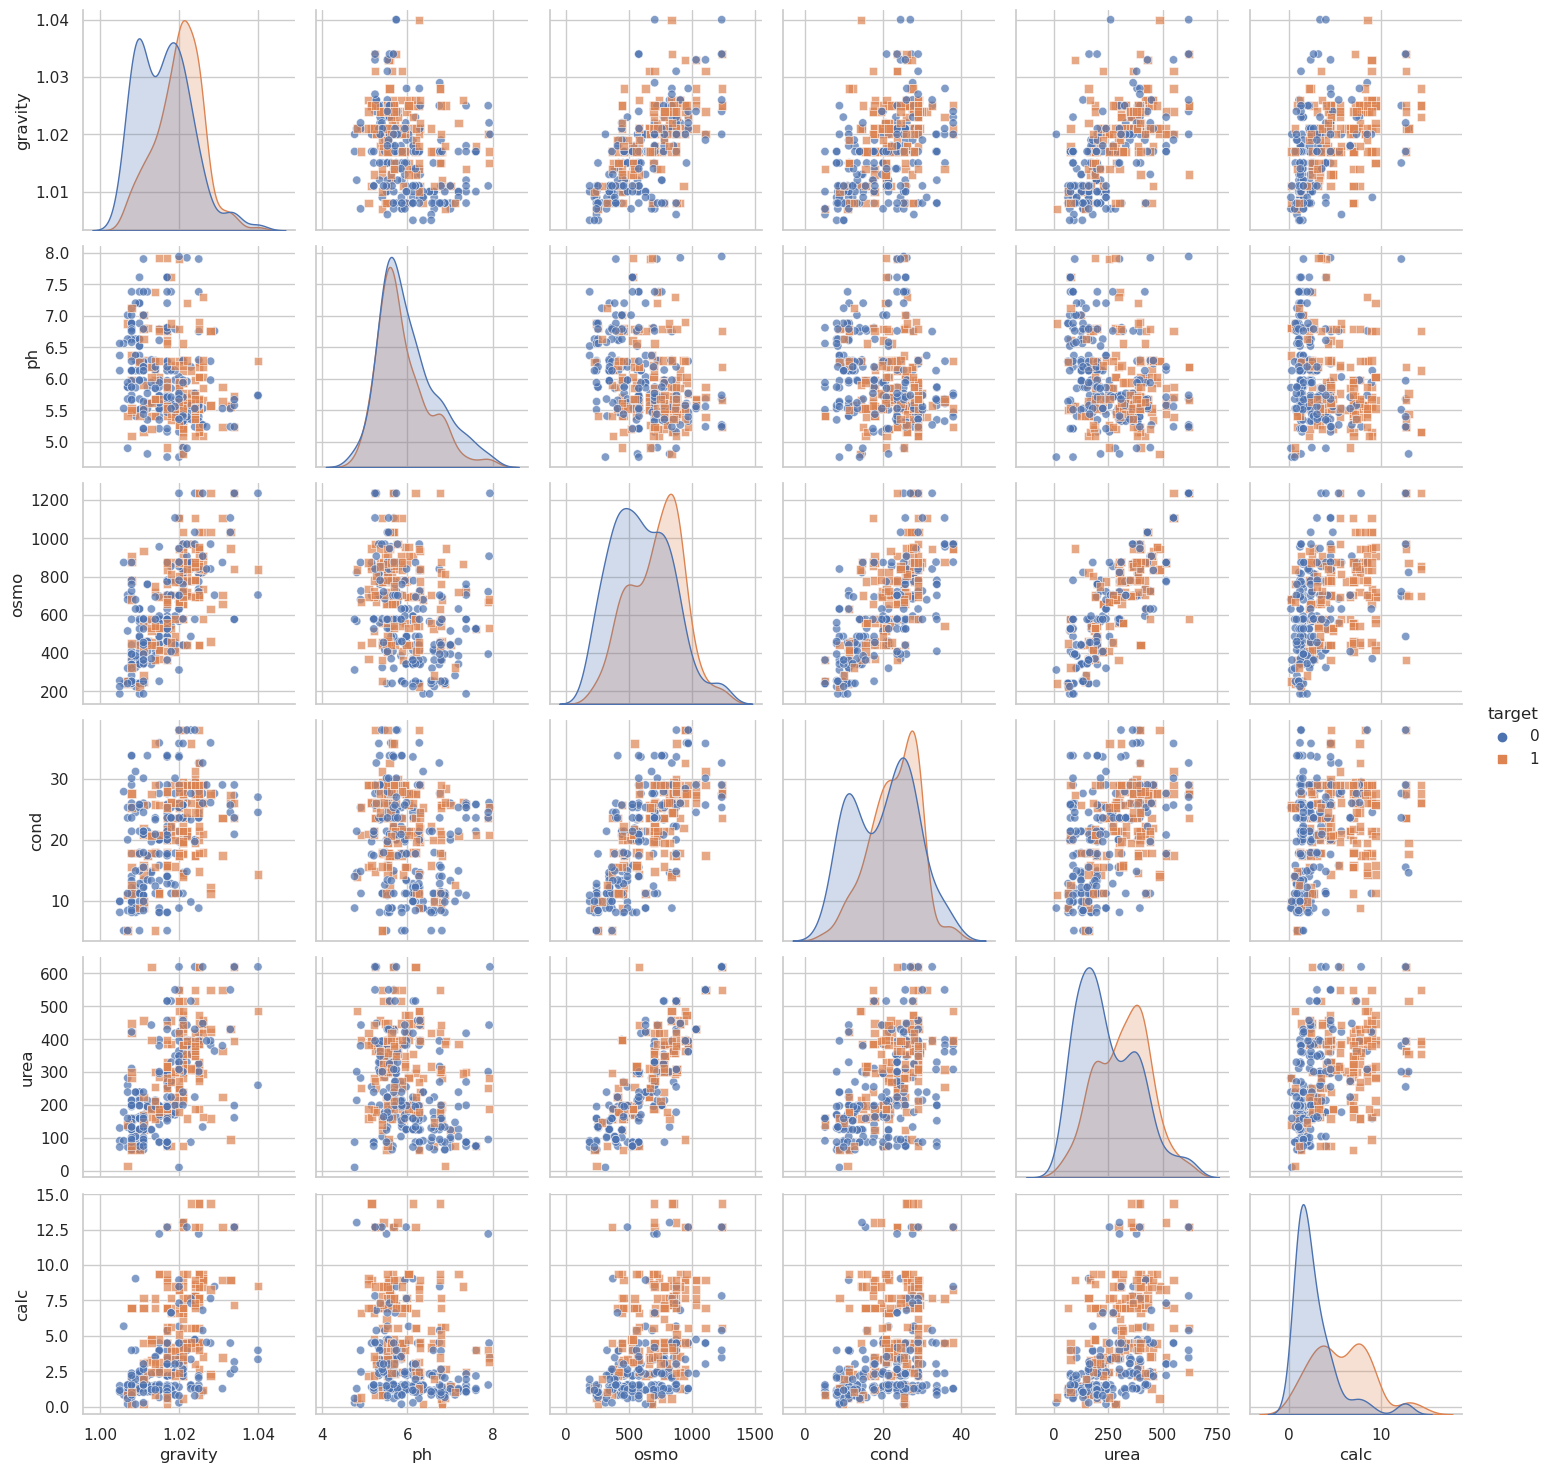

In [5]:
# Scatterplot matrix
sns.set(style='whitegrid')
sns.pairplot(df, hue='target', diag_kind='kde', markers=['o', 's'], plot_kws={'alpha': 0.7})
plt.show()

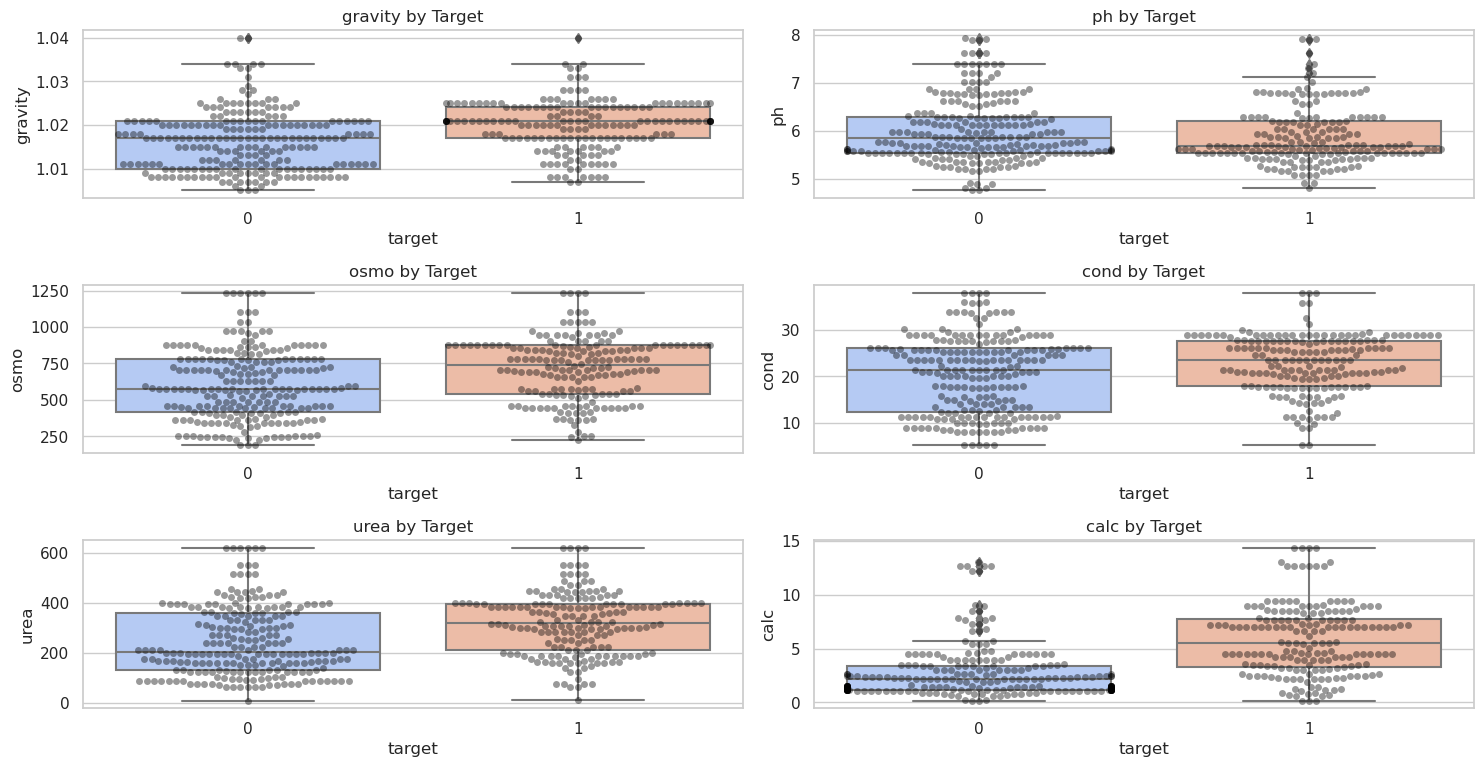

In [6]:
# Box plots and swarm plots
plt.figure(figsize=(15, 15))
for i, column in enumerate(data_without_target.columns):
    plt.subplot(len(data_without_target.columns), 2, i + 1)
    sns.boxplot(x='target', y=column, data=df, palette='coolwarm')
    sns.swarmplot(x='target', y=column, data=df, color='black', alpha=0.4)
    plt.title(f'{column} by Target')
plt.tight_layout()
plt.show()

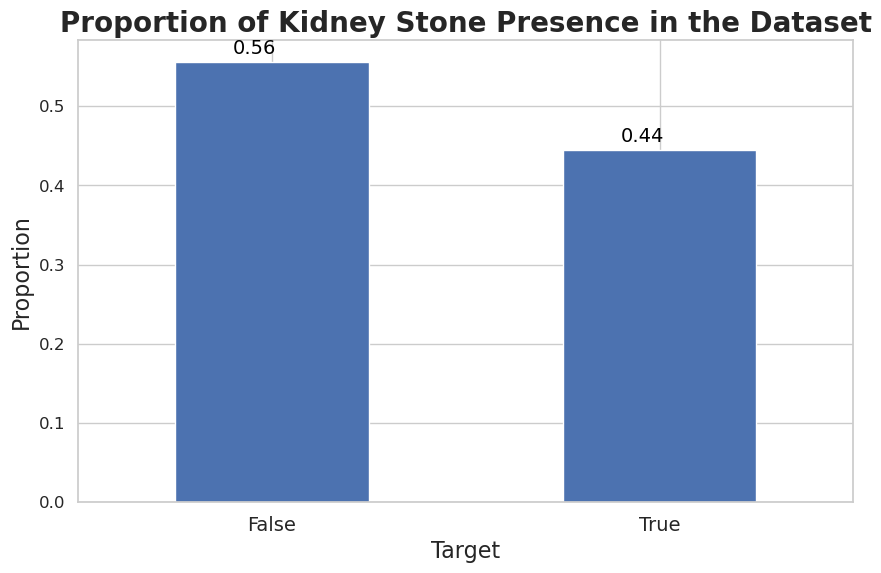

In [7]:

target_counts = df['target'].value_counts(normalize=True)

ax = target_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

ax.set_xlabel('Target', fontsize=16)
ax.set_ylabel('Proportion', fontsize=16)
ax.set_title('Proportion of Kidney Stone Presence in the Dataset', fontsize=20, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['False', 'True'], rotation=0, fontsize=14)
plt.yticks(fontsize=12)

for i, v in enumerate(target_counts):
    ax.text(i - 0.1, v + 0.01, f'{v:.2f}', fontsize=14, color='black')

plt.show()

The dataset exhibits a slight class imbalance, with the majority class ('False') accounting for 56% and the minority class ('True') accounting for 44% of the total instances. While this is not a severe imbalance, it can still introduce bias in the model and impact its performance. To mitigate this issue, we can use the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples for the minority class. By doing this, we can balance the class distribution and potentially improve the model's ability to generalize and make accurate predictions for both classes.

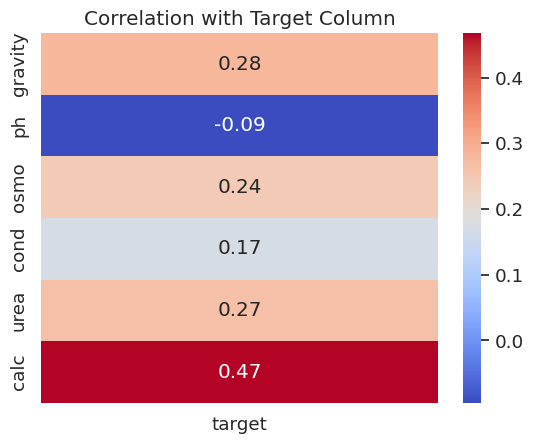

In [8]:
# compute the correlation matrix with the target column
corr = df.corr()

# extract the correlations with the target column
target_corr = corr['target'].drop('target')

# create a heatmap of the correlations with the target column
sns.set(font_scale=1.2)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Target Column')
plt.show()

# <span style="color:#E888BB; font-size: 1%;">Feature Engineering</span>
<div style="padding: 35px;color:white;margin:10;font-size:170%;text-align:left;display:fill;border-radius:10px;background-color:#F1C40F;overflow:hidden;background-image: url(https://images.pexels.com/photos/3850689/pexels-photo-3850689.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1)"><b><span style='color:black'>Feature Engineering </span></b> </div>



1. `Specific gravity` to `calcium` ratio: 

    This feature can help understand how concentrated the `calcium` content is in the `urine`, which can potentially affect stone formation.
    
    **formula : specific_gravity_calcium_ratio = specific_gravity x calcium_concentration**
  
2. `Calcium` to `conductivity` product:

    This feature can help determine the proportion of `calcium` ions relative to the total ion content, which might impact stone formation risk.

   **formula : calcium_conductivity_product = calcium_concentration * conductivity**
   
3. ` Calcium` and `pH` product:

    As the solubility of different types of kidney stones can be affected by `pH`, creating a product term between `calcium concentration` and `pH` could   provide insight into the combined impact of these factors on kidney stone formation.

    **formula : calcium_pH_product = calcium_concentration * pH**
    
4. ` Urea` and `pH` product:

    A high protein diet can increase the risk of kidney stone formation. Since urea is a waste product of protein metabolism, creating a product term between `urea concentration` and `pH` could help capture the combined effect of diet and urine acidity on stone formation risk.

    **formula : urea_pH_product = urea_concentration * pH**
    
5. `Osmolarity` and `calcium` product:

    A high osmolarity indicates concentrated urine, which could contribute to the formation of kidney stones. Creating a product term between `osmolarity` and `calcium concentration` might help capture the combined effect of urine concentration and calcium levels on stone formation risk.

    **formula : osmolarity_calcium_product = osmolarity * calcium_concentration**

6. Estimated urine volume:

    This feature estimates the urine volume based on `specific gravity` and `osmolarity`, which can provide insight into the concentration of solutes in the urine and their potential to form kidney stones.

    **formula: urine_volume = (1000 * specific_gravity * osmolarity) / (18 * 1.001)**

In [9]:
# Calculate estimated urine volume
df['urine_volume'] = (1000 * df['gravity'] * df['osmo']) / (18 * 1.001)
# Specific gravity to calcium ratio
df['specific_gravity_calcium_ratio'] = df['gravity'] / df['calc']
# Calcium to conductivity product
df['calcium_conductivity_ratio'] = df['calc'] / df['cond']
# Calcium and pH product
df['calcium_pH_interaction'] = df['calc'] * df['ph']
# Urea and pH product
df['urea_pH_interaction'] = df['urea'] * df['ph']
# Osmolarity and calcium product
df['osmolarity_calcium_interaction'] = df['osmo'] * df['calc']

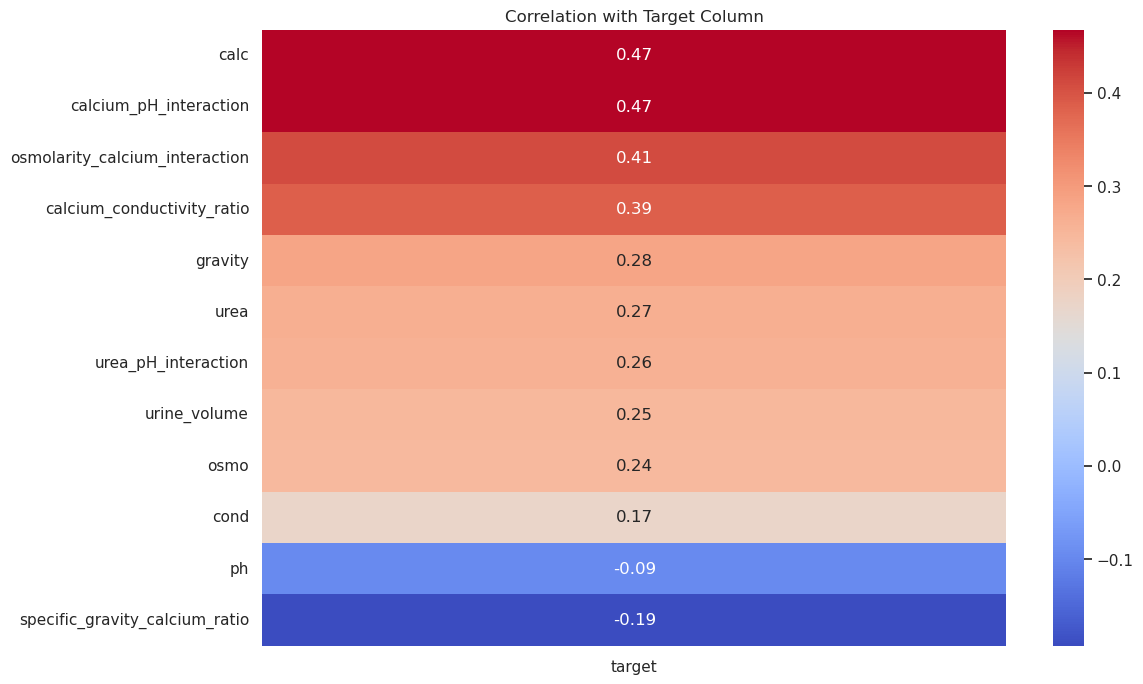

In [10]:
# correlation matrix
corr = df.corr()
target_corr = corr['target'].drop('target').sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Target Column')
plt.show()

In [11]:
#Finding important feature

# Target variable
X = df.drop('target', axis=1)  
y = df['target']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#show accuracy
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))
print("Confusion Matrix:", confusion_matrix(y_test, y_pred))

#check feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(feature_importance_df)

Accuracy: 0.6987951807228916
Classification Report:               precision    recall  f1-score   support

           0       0.70      0.78      0.74        45
           1       0.70      0.61      0.65        38

    accuracy                           0.70        83
   macro avg       0.70      0.69      0.69        83
weighted avg       0.70      0.70      0.70        83

Confusion Matrix: [[35 10]
 [15 23]]
                           Feature  Importance
9           calcium_pH_interaction    0.157963
7   specific_gravity_calcium_ratio    0.122901
11  osmolarity_calcium_interaction    0.107651
8       calcium_conductivity_ratio    0.097782
5                             calc    0.084923
1                               ph    0.073905
6                     urine_volume    0.073000
10             urea_pH_interaction    0.070232
3                             cond    0.060729
2                             osmo    0.054219
4                             urea    0.050516
0                   

In [12]:
num_features = 5  # Choose an appropriate number based on your experimentation
selected_features = feature_importance_df.nlargest(num_features, 'Importance')['Feature'].values

# Create a new DataFrame with only the feature you have selected
X_top = X[selected_features]
print(selected_features)

['calcium_pH_interaction' 'specific_gravity_calcium_ratio'
 'osmolarity_calcium_interaction' 'calcium_conductivity_ratio' 'calc']


In [13]:
# Data Preprocessing

# Handle class imbalance
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X[selected_features], y)

# Use SMOTE-resampled data for training
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Making a Prediction

**Regression Model**

In [14]:
# Prediction Model (Regression)
models = [
    ('LogisticRegression', LogisticRegression(max_iter=10000, random_state=42)),
    ('SVC', SVC(random_state=42)),
    ('RandomForestClassifier', RandomForestClassifier(random_state=42)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)),
    ('XGBoost', xgb.XGBClassifier(random_state=42)),
    ('LightGBM', lgb.LGBMClassifier(random_state=42)),
    ('CatBoost', cb.CatBoostClassifier(random_state=42, verbose=0))
]

# Train and evaluate the models
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} accuracy: {accuracy:.4f}")

LogisticRegression accuracy: 0.7065
SVC accuracy: 0.7283
RandomForestClassifier accuracy: 0.7174
GradientBoostingClassifier accuracy: 0.7391
XGBoost accuracy: 0.7065
LightGBM accuracy: 0.7391
CatBoost accuracy: 0.7391


**Stack Analysis**

In [15]:
#do a stack analysis for better prediction

lr = LogisticRegression()
svc = SVC(probability=True)
rf = RandomForestClassifier()
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()

meta_model = LogisticRegression()

# Define the stacking classifier
stacking_classifier = StackingCVClassifier(
    classifiers=[lr, svc, rf, gbc, mlp],
    meta_classifier=meta_model,
    use_probas=True,
    random_state=42
)

# Fit the stacking classifier
stacking_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_val_pred = stacking_classifier.predict(X_val_scaled)

# Calculate the accuracy
stacking_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Stacking Classifier accuracy: {stacking_accuracy:.4f}")

Stacking Classifier accuracy: 0.7391


**Neural Network**

In [16]:
# If you are not satisfied with the result it's time to do a neural network
def create_nn_model(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

nn_model = create_nn_model(X_train_scaled.shape[1])

# Train
nn_history = nn_model.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
    epochs=100, batch_size=32, verbose=0
)

# Evaluate
nn_accuracy = nn_history.history['val_accuracy'][-1]
print(f"Neural Network accuracy: {nn_accuracy:.4f}")

Neural Network accuracy: 0.7500


**Deep Learning**

In [17]:
#If you want more accuracy Let's optimize the neural network
def create_deeper_nn_model(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

deeper_nn_model = create_deeper_nn_model(X_train_scaled.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

deeper_nn_history = deeper_nn_model.fit(
    X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
    epochs=200, batch_size=16, verbose=0,
    callbacks=[early_stopping, reduce_lr]
)

deeper_nn_accuracy = deeper_nn_history.history['val_accuracy'][-1]
print(f"Deeper Neural Network accuracy: {deeper_nn_accuracy:.4f}")

Deeper Neural Network accuracy: 0.7500


# Testing

In [18]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')

In [19]:
# Calculate estimated urine volume
test_df['urine_volume'] = (1000 * test_df['gravity'] * test_df['osmo']) / (18 * 1.001)
# Specific gravity to calcium ratio
test_df['specific_gravity_calcium_ratio'] = test_df['gravity'] / test_df['calc']
# Calcium to conductivity product
test_df['calcium_conductivity_ratio'] = test_df['calc'] / test_df['cond']
# Calcium and pH product
test_df['calcium_pH_interaction'] = test_df['calc'] * test_df['ph']
# Urea and pH product
test_df['urea_pH_interaction'] = test_df['urea'] * test_df['ph']
# Osmolarity and calcium product
test_df['osmolarity_calcium_interaction'] = test_df['osmo'] * test_df['calc']

In [20]:
# Preprocess the test dataset
X_test = test_df[selected_features]

# Scale the test dataset
X_test_scaled = scaler.transform(X_test)

# Make predictions using _____
#y_test_pred = <put the name of the model you want to use here>.predict(X_test_scaled)
y_test_pred = deeper_nn_model.predict(X_test_scaled)

# Create a new DataFrame with ID column and predicted probabilities
result_df = pd.DataFrame({'id': test_df['id'], 'predicted_probability': y_test_pred.reshape(-1)})

9/9 [==============================] - 0s 1ms/step


In [21]:
result_df.head(20)

,id,predicted_probability
0,414,0.130578
1,415,0.522123
2,416,0.908085
3,417,0.515355
4,418,0.326554
5,419,0.636611
6,420,0.605006
7,421,0.894209
8,422,0.193371
9,423,0.106844


In [22]:
# Save the result DataFrame as a CSV file
result_df.to_csv('submission.csv', index=False)